王の作ったコード


In [2]:
from urllib import request 
import logging
from pathlib import Path
import numpy as np
import re
import MeCab
import random
from gensim import corpora, models
import pandas as pd
from tqdm import tqdm

# データ読み込み

In [1]:
# df_content = pd.read_csv('2019-01-01-content.csv')
# df_content['text'] = df_content['text'].replace(np.nan, "", regex=True)
# df_content['lang'] = df_content['lang'].replace(np.nan, "", regex=True)
# # df_nonna = df_content[df_content['text'].isna() == False]
# # df_nonna = df_nonna[df_nonna['lang'].isna() == False]
# # len(df_nonna)

データベースから一年分のデータを読み込む

In [3]:
from urllib.parse import urlparse
from sqlalchemy import create_engine
import pandas as pd


#dbserver_sampleの中身を書き換えて、ファイル名をdbserver.txtに変更
#dbserver.txtからdbのpathを読み込む

db_path = open('dbserver_sample.txt', 'r').read()

In [6]:
#dbに接続し、テーブルから取ってきたデータをdataframeに変換
from sqlalchemy.sql import text
from datetime import datetime, date, timezone, timedelta

url = urlparse(db_path) 

conn = create_engine('mysql://{user}:{password}@{host}:{port}/{database}?charset=utf8'.format(host = url.hostname, port=url.port, user = url.username, password= url.password, database = url.path[1:]),encoding='utf-8')

table='raw_from_api'
# sql_read=text("select * from qiita_db.raw_from_api where likes_count = {};".format(640))
#sql_read=text("select * from qiita_db.raw_from_api where created_at = '{}';".format('2019-01-01 10:53:44'))
sql_read=text("select * from qiita_db.raw_from_api where created_at between'{}' and '{}';".format('2019-01-01 00:00:00','2019-01-31 00:00:00'))

df = pd.read_sql(sql_read, conn)
df.head(5)

,id,article_id,title,created_at,updated_at,likes_count,comments_count,tags_str,user_id,user_permanent_id,url,html,tokens,similar_articles
0,469421,a0ae89bb2ff08c50d4ec,Mac上でWindowsのコマンドラインアプリをビルドする,2019-01-01 09:29:37,2019-01-01 09:29:37,0,0,"C,Mac,MacOSX,wine,MinGW",ossan-buhibuhi,101524,https://qiita.com/ossan-buhibuhi/items/a0ae89b...,<p>Chicken Schemeがファイルパス関係でどう動作するか確認したかったんだけど、...,Chicken Scheme が ファイル パス 関係 で どう 動作 する か 確認 し ...,None
1,469420,298d3bf877b73ce50612,Webアプリ開発を試したいJSライブラリ,2019-01-01 09:33:15,2019-01-01 09:33:15,3,0,JavaScript,giogiokuma,60856,https://qiita.com/giogiokuma/items/298d3bf877b...,<p>自分が試したいJSライブラリをメモ（2019）<br>\n<strong><a hre...,自分 が 試し たい JS ライブラリ を メモ （ 2019 ） オーディオスプライト に...,None
2,469419,2bad5f7dda7c35afc9fa,Qiitaで自分のContributinランキングが分かる最強システムの秘密とは‥？ RT ...,2019-01-01 09:55:56,2019-01-01 09:56:15,0,0,"Qiita,Twitter",YumaInaura,89618,https://qiita.com/YumaInaura/items/2bad5f7dda7...,"<p><a href=""https://mogya.github.io/qiitaRank/...","エンジニア ランキング vQiita の contributions 値 から , 日本 で...",None
3,469418,d0fb65f6800253598e45,JSの日付の条件分岐について,2019-01-01 10:08:06,2019-01-01 10:08:06,0,0,JavaScript,suzuki_san,317636,https://qiita.com/suzuki_san/items/d0fb65f6800...,<p>JavaScriptで１月１日から表示する項目をDateを使って出し分けようとしたが、...,JavaScript で １月 １ 日 から 表示 する 項目 を Date を 使っ て ...,None
4,469417,5590cdde6f61ef729ffd,@Qiita のTwitter通知。ツイート内容にアカウント名を埋め込むだけじゃダメ‥？,2019-01-01 10:09:30,2019-01-01 10:09:30,0,0,"Qiita,Twitter",YumaInaura,89618,https://qiita.com/YumaInaura/items/5590cdde6f6...,"\n<h1>\n<span id=""アカウント名は入らない"" class=""fragment...",アカウント名 は 入ら ない Qiita は ユーザー ごと に Twitter の アカウ...,None


In [61]:
# 欠損値の数と割合を求める
def missingval_table(df):
    mv_df = pd.DataFrame(df.isnull().sum())
    mv_df = mv_df.rename(columns={0:'null count'})
    mv_df['null count(%)'] = mv_df['null count']/len(df)*100
    mv_df['variation'] = df.nunique().values
    mv_df['variation(%)'] = df.nunique().values/len(df)*100
    return mv_df

missingval_table(df_content)

,null count,null count(%),variation,variation(%)
Unnamed: 0,0,0.0,8248,100.000000
id,0,0.0,8248,100.000000
text,0,0.0,8206,99.490786
lang,0,0.0,2985,36.190592
article_id,0,0.0,8248,100.000000
likes_count,0,0.0,210,2.546072
tags_str,0,0.0,6119,74.187682
title,0,0.0,8241,99.915131
url,0,0.0,8248,100.000000


# 前処理

In [62]:
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt")
stopwords = [line.decode("utf-8").strip() for line in res]
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt")
stopwords += [line.decode("utf-8").strip() for line in res]

class Tokenizer:
    def __init__(self, stopwords, parser=None, include_pos=None, exclude_posdetail=None, exclude_reg=None):
    
        self.stopwords = stopwords
        self.include_pos = include_pos if include_pos else  ["名詞", "動詞", "形容詞"]
        self.exclude_posdetail = exclude_posdetail if exclude_posdetail else ["接尾", "数"]
        self.exclude_reg = exclude_reg if exclude_reg else r"$^"  # no matching reg
        if parser:
            self.parser = parser
        else:
            mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
            self.parser = mecab.parse
            

    def tokenize(self, text, show_pos=False):
        text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+", "", text)    #URL
        text = re.sub(r"\"?([-a-zA-Z0-9.`?{}]+\.jp)\"?" ,"", text)  # xxx.jp 
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = [
            i[2] if not show_pos else (i[2],i[3]) for i in l 
                if len(i) >=4 # has POS.
                    and i[3].split("-")[0] in self.include_pos
                    and i[3].split("-")[1] not in self.exclude_posdetail
                    and not re.search(r"(-|−)\d", i[2])
                    and not re.search(self.exclude_reg, i[2])
                    and i[2] not in self.stopwords]
        return res

In [63]:
mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
t = Tokenizer(stopwords + ["…。"] , mecab.parse, exclude_reg=r"\d(年|月|日)")

In [64]:
t.tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

['認める', '自分自身', '若さ故の過ち']

In [65]:
t.tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。", show_pos=True)

[('認める', '動詞-自立'), ('自分自身', '名詞-固有名詞-一般'), ('若さ故の過ち', '名詞-固有名詞-一般')]

In [66]:
# doc_path = "./"
# doc_dir = Path(doc_path)
# dirs = [i for i in doc_dir.iterdir() if i.is_dir()]
# dirs

In [67]:
# articles = [a for categ in dirs for a in categ.iterdir()]
# random.shuffle(articles)

# print(articles[:3])
# num_docs = len(articles)
# print("# of docs:", num_docs)

In [68]:
# num_docs = len(articles)
# num_docs

In [69]:
# class Doc_manager():
#     def __init__(self, docs):
#         self.docs = docs
        
#     def read_doc(self, doc_id):
#         with self.docs[doc_id].open() as f:
#             print(f.read())

In [70]:
# dm = Doc_manager(articles)

In [71]:
docs = []
for texts in df_content['text']:
    docs.append(t.tokenize(texts))

In [72]:
docs[0][:10]

['chicken', 'scheme', 'ファイル', 'パス', '動作', 'する', '確認', 'する', 'ん', 'wine']

In [73]:
d = corpora.Dictionary(docs)

adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(72990 unique tokens: ['CURRENT', 'MAC', 'MONO', 'MinGW', 'OSDN']...) from 8248 documents (total 1896715 corpus positions)


In [74]:
print(len(d))
print(d[1289])
print("python id:",d.token2id["python"])
print("C++ id:",d.token2id["C++"])
print(d.doc2bow(["探索","ノード"]))

72990
なくなる
python id: 1433
C++ id: 3875
[(1799, 1), (9579, 1)]


In [75]:
d.filter_extremes(no_below=5, no_above=0.2)
# nob_below以下の個数の単語を無視
# no_aboveの割合以上に出てくる単語を無視
d.compactify()
# idを振り直してコンパクトにする。

discarding 58818 tokens: [('OSDN', 1), ('SourceForge', 3), ('andale', 1), ('chicken', 1), ('conemu', 3), ('easywine', 2), ('nihonshu', 1), ('replacements', 1), ('ある', 5347), ('いる', 6125)]...
keeping 14172 tokens which were in no less than 5 and no more than 1649 (=20.0%) documents
resulting dictionary: Dictionary(14172 unique tokens: ['CURRENT', 'MAC', 'MONO', 'MinGW', 'cmd']...)


In [76]:
dic_num = len(d)
dic_num

14172

In [77]:
d[0]

'CURRENT'

In [78]:
[(d[t[0]],t[1])for t in sorted(d.dfs.items(),key=lambda x:x[1],reverse=True)]

[('データ', 1611),
 ('処理', 1586),
 ('簡単', 1568),
 ('コマンド', 1551),
 ('問題', 1518),
 ('いい', 1514),
 ('情報', 1504),
 ('エラー', 1485),
 ('機能', 1457),
 ('実装', 1433),
 ('内容', 1429),
 ('可能', 1418),
 ('使える', 1397),
 ('取得', 1364),
 ('まとめる', 1350),
 ('入力', 1348),
 ('入れる', 1348),
 ('くれる', 1329),
 ('起動', 1327),
 ('対応', 1316),
 ('部分', 1299),
 ('考える', 1279),
 ('開発', 1251),
 ('値', 1245),
 ('ん', 1239),
 ('いう', 1231),
 ('説明', 1199),
 ('画面', 1193),
 ('出力', 1183),
 ('参照', 1180),
 ('多い', 1178),
 ('言う', 1176),
 ('定義', 1172),
 ('やすい', 1161),
 ('状態', 1159),
 ('しれる', 1152),
 ('最後', 1139),
 ('選択', 1131),
 ('動作', 1121),
 ('アクセス', 1116),
 ('入る', 1110),
 ('関数', 1103),
 ('よい', 1099),
 ('持つ', 1097),
 ('最初', 1095),
 ('バージョン', 1058),
 ('調べる', 1049),
 ('生成', 1044),
 ('読む', 1029),
 ('用意', 1026),
 ('動く', 1000),
 ('手順', 1000),
 ('複数', 957),
 ('デフォルト', 938),
 ('メモ', 937),
 ('保存', 936),
 ('知る', 919),
 ('記述', 918),
 ('以外', 904),
 ('通り', 898),
 ('python', 894),
 ('サイト', 887),
 ('ページ', 886),
 ('()', 880),
 ('便利', 880),
 ('管理', 876),

In [79]:
corpus = [d.doc2bow(w) for w in docs]
test_size = int(len(corpus) * 0.1)
test_corpus = corpus[:test_size]
train_corpus= corpus[test_size:]
print("test size: ", len(test_corpus))
print("train size: ", len(train_corpus))

test size:  824
train size:  7424


# LDAの学習

In [80]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [81]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=d, num_topics=50, passes=10)

using symmetric alpha at 0.02
using symmetric eta at 0.02
using serial LDA version on this node
running online (multi-pass) LDA training, 50 topics, 10 passes over the supplied corpus of 8248 documents, updating model once every 2000 documents, evaluating perplexity every 8248 documents, iterating 50x with a convergence threshold of 0.001000
PROGRESS: pass 0, at document #2000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #49 (0.020): 0.011*"遷移" + 0.008*"状態" + 0.006*"docker" + 0.005*"定義" + 0.004*"入力" + 0.004*"機能" + 0.004*"コンテナ" + 0.004*"実装" + 0.004*"情報" + 0.004*"起動"
topic #45 (0.020): 0.006*"出力" + 0.005*"パッケージ" + 0.005*"関数" + 0.004*"キーボード" + 0.004*"画面" + 0.004*"情報" + 0.004*"ビルド" + 0.003*"データ" + 0.003*"回路" + 0.003*"コマンド"
topic #27 (0.020): 0.005*"データ" + 0.005*"python" + 0.004*"web" + 0.004*"エラー" + 0.003*"入力" + 0.003*"処理" + 0.003*"情報" + 0.003*"参照" + 0.003*"画面" + 0.003*"起動"
topic #35 (0.020): 0.005*"データ" + 0.004*"取得" + 0.004*"API" + 0.004*"値" + 0.003*"複素数" 

topic #15 (0.020): 0.085*"画像" + 0.011*"表す" + 0.011*"vec" + 0.011*"確率" + 0.010*"頂点" + 0.010*"変換" + 0.009*"観測" + 0.007*"考える" + 0.007*"生成" + 0.007*"SIGMA"
topic #40 (0.020): 0.069*"TO" + 0.052*"IS" + 0.041*"AND" + 0.021*"ON" + 0.018*"YOU" + 0.018*"BY" + 0.015*"It" + 0.013*"WITH" + 0.010*"AN" + 0.009*"WILL"
topic #28 (0.020): 0.055*"インスタンス" + 0.039*"ノード" + 0.026*"EC2" + 0.021*"VPC" + 0.018*"グループ" + 0.015*"セキュリティ" + 0.014*"アクセス" + 0.012*"リソース" + 0.012*"サブネット" + 0.011*"接続"
topic #47 (0.020): 0.040*"コマンド" + 0.030*"ディレクトリ" + 0.025*"git" + 0.024*"GitHub" + 0.021*"リポジトリ" + 0.015*"管理" + 0.014*"プロジェクト" + 0.011*"バージョン" + 0.009*"テンプレート" + 0.009*"CLI"
topic diff=1.457496, rho=0.404094
-8.684 per-word bound, 411.2 perplexity estimate based on a held-out corpus of 248 documents with 41820 words
PROGRESS: pass 1, at document #8248/8248
merging changes from 248 documents into a model of 8248 documents
topic #18 (0.020): 0.018*"rails" + 0.014*"rb" + 0.012*"Folder" + 0.012*"バージョン" + 0.011*"ダウンロード" + 0.011*

topic #23 (0.020): 0.024*"ユーザー" + 0.022*"イベント" + 0.016*"メソッド" + 0.013*"アクション" + 0.013*"db" + 0.013*"処理" + 0.012*"削除" + 0.012*"画面" + 0.011*"ページ" + 0.010*"ログイン"
topic diff=0.424270, rho=0.350845
PROGRESS: pass 3, at document #6000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #4 (0.020): 0.072*"サービス" + 0.036*"CLOUD" + 0.019*"データ" + 0.018*"ジョブ" + 0.014*"Kubernetes" + 0.013*"概要" + 0.013*"データベース" + 0.013*"管理" + 0.013*"可能" + 0.012*"提供"
topic #7 (0.020): 0.081*"データ" + 0.034*"取得" + 0.029*"テーブル" + 0.021*"出力" + 0.016*"変換" + 0.013*"バイト" + 0.013*"文字列" + 0.013*"SQL" + 0.012*"文字" + 0.012*"CSV"
topic #34 (0.020): 0.020*"サイト" + 0.019*"押す" + 0.017*"ページ" + 0.012*"ボタン" + 0.011*"検索" + 0.011*"機能" + 0.010*"入力" + 0.010*"選択" + 0.010*"勉強" + 0.010*"ツール"
topic #43 (0.020): 0.087*"AWS" + 0.029*"S3" + 0.028*"AZURE" + 0.017*"lambda" + 0.014*"デプロイ" + 0.012*"IOT" + 0.012*"バケット" + 0.012*"iam" + 0.012*"SDK" + 0.012*"Amazon"
topic #49 (0.020): 0.032*"起動" + 0.028*"選択" + 0.023*"windows" + 0

topic #45 (0.020): 0.074*"キー" + 0.042*"キーボード" + 0.026*"スイッチ" + 0.024*"DP" + 0.023*"購入" + 0.016*"コレクション" + 0.013*"キャップ" + 0.013*"RPM" + 0.013*"温度" + 0.010*"自作"
topic #1 (0.020): 0.068*"関数" + 0.037*"引数" + 0.035*"テスト" + 0.030*"定義" + 0.026*"メソッド" + 0.024*"値" + 0.023*"変数" + 0.022*"型" + 0.019*"処理" + 0.019*"返す"
topic #7 (0.020): 0.080*"データ" + 0.039*"取得" + 0.029*"テーブル" + 0.021*"出力" + 0.021*"バイト" + 0.013*"id" + 0.013*"文字" + 0.013*"変換" + 0.012*"情報" + 0.012*"SQL"
topic #9 (0.020): 0.023*"開発" + 0.018*"プロジェクト" + 0.015*"構築" + 0.014*"Heroku" + 0.012*"デプロイ" + 0.011*"ビルド" + 0.010*"アプリ" + 0.009*"app" + 0.009*"web" + 0.008*"起動"
topic diff=0.190327, rho=0.314285
PROGRESS: pass 5, at document #4000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #3 (0.020): 0.032*"クリック" + 0.032*"認証" + 0.023*"登録" + 0.022*"取得" + 0.021*"id" + 0.019*"ログイン" + 0.019*"API" + 0.018*"トークン" + 0.018*"URL" + 0.018*"アカウント"
topic #45 (0.020): 0.069*"キー" + 0.054*"DP" + 0.035*"キーボード" + 0.023*"コレクション" + 0.022*

topic diff=0.098650, rho=0.299826
-8.268 per-word bound, 308.3 perplexity estimate based on a held-out corpus of 248 documents with 41820 words
PROGRESS: pass 6, at document #8248/8248
merging changes from 248 documents into a model of 8248 documents
topic #45 (0.020): 0.082*"キー" + 0.036*"キーボード" + 0.029*"DP" + 0.028*"スイッチ" + 0.019*"購入" + 0.015*"コレクション" + 0.014*"RPM" + 0.011*"自作" + 0.011*"読み方" + 0.010*"シート"
topic #38 (0.020): 0.028*"ディスク" + 0.026*"トランザクション" + 0.024*"space" + 0.023*"パーティション" + 0.018*"Blockchain" + 0.017*"仮想" + 0.016*"容量" + 0.014*"BOOT" + 0.013*"ブロック" + 0.011*"ISO"
topic #42 (0.020): 0.043*"要因" + 0.028*"分析" + 0.024*"スタイル" + 0.021*"データ" + 0.021*"用いる" + 0.021*"平均" + 0.018*"Style" + 0.017*"city" + 0.017*"説明" + 0.015*"変数"
topic #39 (0.020): 0.067*"デバイス" + 0.026*"Qi" + 0.024*"言う" + 0.024*"group" + 0.022*"入力" + 0.021*"iPhone" + 0.018*"込" + 0.016*"音声" + 0.015*"extension" + 0.015*"読"
topic #44 (0.020): 0.028*"チーム" + 0.022*"ふりかえる" + 0.019*"匿名" + 0.018*"組織" + 0.018*"メンバー" + 0.012*"

topic #39 (0.020): 0.077*"デバイス" + 0.033*"言う" + 0.030*"Twitter" + 0.028*"iPhone" + 0.025*"入力" + 0.025*"音声" + 0.018*"しれる" + 0.017*"group" + 0.016*"込" + 0.016*"extension"
topic #31 (0.020): 0.025*"client" + 0.019*"part" + 0.013*"IP" + 0.013*"AND" + 0.011*"server" + 0.010*"web" + 0.010*"いいね" + 0.010*"パケット" + 0.010*"address" + 0.008*".S"
topic #43 (0.020): 0.093*"AWS" + 0.031*"S3" + 0.031*"AZURE" + 0.019*"デプロイ" + 0.017*"lambda" + 0.015*"リソース" + 0.015*"Amazon" + 0.014*"バケット" + 0.014*"権限" + 0.013*"リージョン"
topic #7 (0.020): 0.100*"データ" + 0.041*"取得" + 0.032*"テーブル" + 0.017*"出力" + 0.015*"バイト" + 0.014*"id" + 0.014*"検索" + 0.013*"SQL" + 0.013*"CSV" + 0.012*"情報"
topic diff=0.073905, rho=0.276037
PROGRESS: pass 8, at document #8000/8248
merging changes from 2000 documents into a model of 8248 documents
topic #7 (0.020): 0.099*"データ" + 0.044*"取得" + 0.033*"テーブル" + 0.017*"出力" + 0.015*"検索" + 0.015*"id" + 0.013*"情報" + 0.013*"バイト" + 0.013*"SQL" + 0.012*"CSV"
topic #14 (0.020): 0.096*"テスト" + 0.028*"AI" + 0.016

In [82]:
def get_topic_words(topic_id):
    for t in lda.get_topic_terms(topic_id):
        print("{}: {}".format(d[t[0]], t[1]))
for t in range(10):
    print("Topic # ",t)
    get_topic_words(t)
    print("\n")

Topic #  0
表現: 0.028339216485619545
ゲーム: 0.019377943128347397
システム: 0.015697527676820755
持つ: 0.01383525412529707
機能: 0.0110445162281394
用いる: 0.010074008256196976
移動: 0.00948379561305046
コンポーネント: 0.007769191171973944
考える: 0.00740049546584487
禁止: 0.007297890726476908


Topic #  1
関数: 0.07425612956285477
引数: 0.03785615786910057
定義: 0.03140704333782196
値: 0.027587153017520905
型: 0.026733843609690666
変数: 0.025913169607520103
処理: 0.020349448546767235
メソッド: 0.018932931125164032
返す: 0.01800561510026455
テスト: 0.01645251177251339


Topic #  2
編集: 0.0347539521753788
conf: 0.025930255651474
ver: 0.024795912206172943
追記: 0.022342896088957787
プラグイン: 0.02075793407857418
コマンド: 0.01992969959974289
ディレクトリ: 0.017665738239884377
vim: 0.016736172139644623
VSCode: 0.016353929415345192
作業: 0.013531693257391453


Topic #  3
認証: 0.03573029115796089
登録: 0.028157399967312813
id: 0.025463974103331566
クリック: 0.024085266515612602
ログイン: 0.02230212464928627
アカウント: 0.022001832723617554
トークン: 0.021273283287882805
URL: 0.

In [83]:
topics = sorted(lda.get_document_topics(corpus[0]), key=lambda t:t[1], reverse=True)
for t in topics[:10]:
    print("{}: {}".format(t[0], t[1]))

49: 0.27843350172042847
18: 0.20183663070201874
6: 0.19705627858638763
11: 0.06437253952026367
9: 0.06320003420114517
17: 0.03995615616440773
33: 0.036825042217969894
12: 0.03515973687171936
40: 0.034847814589738846
46: 0.02417300082743168


In [84]:
for t in topics[:10]:
    print("Topic # ",t[0])
    get_topic_words(t[0])
    print("\n")

Topic #  49
選択: 0.05168396979570389
画面: 0.03504608944058418
開く: 0.031834881752729416
クリック: 0.030572010204195976
入力: 0.022956201806664467
起動: 0.0216389000415802
押す: 0.02021687664091587
タブ: 0.02017885446548462
windows: 0.019733918830752373
キー: 0.013134194537997246


Topic #  18
rails: 0.02575146220624447
Folder: 0.019699016585946083
java: 0.015773098915815353
gem: 0.01393128465861082
rb: 0.013693967834115028
RUBY: 0.011735786683857441
ダウンロード: 0.01172583643347025
バージョン: 0.011339320801198483
フォント: 0.010454223491251469
exe: 0.009828957729041576


Topic #  6
サンプル: 0.07381140440702438
入力: 0.040596988052129745
ANDROID: 0.038041409105062485
合計: 0.036824747920036316
金額: 0.03664037212729454
個数: 0.03224148601293564
iOS: 0.02738613821566105
MAC: 0.024185869842767715
100本: 0.023926500231027603
選択: 0.020990826189517975


Topic #  11
python: 0.056948669254779816
パッケージ: 0.02619951032102108
Ubuntu: 0.01752113737165928
バージョン: 0.01350115891546011
ライブラリ: 0.01335960440337658
ダウンロード: 0.012431560084223747
コマン

In [85]:
df_content['text'][0]

'Chicken Schemeがファイルパス関係でどう動作するか確認したかったんだけど、Wineを使ううえで少しだけ手間取ったのでメモ。Mac上で動作するWineにはいくつか種類があるようなのだが、今回は日本語に対応しているというEasyWineをインストールした。ちなみにNihonshuとゆうのはよく分からないのでインストールしてない。これを起動するとファイルエクスプローラみたいなのが立ち上がる。ここから試しにC:\\windows\\system32\\cmd.exeを起動してみたが、これが全くキー入力を受け付けない。なので、ConEmuというターミナルソフトをインストール。インストールは普通にFinderからインストーラのファイルを開けばEasyWineが実行してくれる。初期状態ではフォントが可変ピッチで表示が崩れていたので、Andale Monoとゆうフォントに変更した。キー入力の反応がもたつくがそれ以外は普通に動作する。Chicken Schemeはコンパイルにgccを使うので、一応MinGWもインストール。なぜかSourceForgeからだとインストーラがダウンロードできなかったので、OSDNの方を利用した。   環境変数PATHの設定にはC:\\windows\\regedit.exeを使用した。キーの場所はHKEY_CURRENT_USER\\Environment。ちなみにフォントのカスタマイズはHKEY_CURRENT_USER\\Software\\Wine\\Fonts\\Replacements。最後蛇足だが、俺が昔作ったフリーソフトを実行してみたところ全部正常に動作した。すげーなEasyWine。いじょう'

In [86]:
all_topics = lda.get_document_topics(corpus, minimum_probability=0)
print(all_topics[0])

[(0, 0.00023557042), (1, 0.00023557042), (2, 0.00023557042), (3, 0.00023557042), (4, 0.00023557042), (5, 0.00023557042), (6, 0.1970604), (7, 0.00023557042), (8, 0.00023557042), (9, 0.06321539), (10, 0.00023557042), (11, 0.06427293), (12, 0.035172414), (13, 0.00023557042), (14, 0.00023557042), (15, 0.00023557042), (16, 0.00023557042), (17, 0.039956596), (18, 0.20185716), (19, 0.00023557042), (20, 0.00023557042), (21, 0.00023557042), (22, 0.00023557042), (23, 0.00023557042), (24, 0.00023557042), (25, 0.00023557042), (26, 0.00023557042), (27, 0.014951953), (28, 0.00023557042), (29, 0.00023557042), (30, 0.00023557042), (31, 0.00023557042), (32, 0.00023557042), (33, 0.036825173), (34, 0.00023557042), (35, 0.00023557042), (36, 0.00023557042), (37, 0.00023557042), (38, 0.00023557042), (39, 0.00023557042), (40, 0.034844927), (41, 0.00023557042), (42, 0.00023557042), (43, 0.00023557042), (44, 0.00023557042), (45, 0.00023557042), (46, 0.024160773), (47, 0.00023557042), (48, 0.00023557042), (49, 

# perplexity

In [87]:
N = sum(count for doc in test_corpus for id, count in doc)
print("N: ",N)

N:  133296


In [88]:
lda.log_perplexity(test_corpus)

-9.494 per-word bound, 721.1 perplexity estimate based on a held-out corpus of 824 documents with 133296 words


-9.494089694334685

In [89]:
bound = lda.bound(test_corpus)/N
bound

-9.493802491534424

In [90]:
perplexity = np.exp2(-lda.log_perplexity(test_corpus))

-9.495 per-word bound, 721.5 perplexity estimate based on a held-out corpus of 824 documents with 133296 words


In [91]:
print("perplexity:", perplexity)

perplexity: 721.4699798840956


# 可視化

In [92]:
all_topics = lda.get_document_topics(corpus, minimum_probability=0)

In [93]:
all_topics[1][0]

(0, 0.0003227673)

In [94]:
with open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")

In [95]:
tags_str = df_content["tags_str"]

lang_s = []
for lang in tags_str:
    lang_s.append(lang.split(",")[0])
len(lang_s)

8248

In [96]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codelang = le.fit_transform(lang_s)
len(codelang)

8248

In [97]:
with open('doc_lda_metadata.tsv','w',encoding='utf-8-sig') as w:
    w.write('Titles\tGenres\n')    
    for i in range(len(lang_s)):       
        w.write("%s\t%s\n" % (lang_s[i],codelang[i]))

# 類似度

In [98]:
doc_topics = np.array([lda[c] for c in corpus])

In [99]:
doc_topics.shape

(8248, 50, 2)

In [100]:
features = np.zeros( (len(doc_topics), 50), float)

for doc_id, t in enumerate(doc_topics):
    for topic_id, weight in t:
        features[doc_id, int(topic_id)] = weight

In [101]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(features, metric="cosine"))

In [102]:
def similar_to(doc_id, num=5, distance=False):
    doc = pairwise[doc_id]
    ids = np.argsort(doc)[1: num+1] # the most similar is self.
    if distance:
        dist = np.sort(doc)[1: num+1]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

In [103]:
similar_to(0, num=10, distance=True)

[(6438, 0.12889974621914735),
 (6052, 0.17647560172004162),
 (8166, 0.17845068567434308),
 (6420, 0.18214120012614488),
 (6389, 0.18343393530710916),
 (528, 0.18990333258866443),
 (596, 0.19241194877568757),
 (3024, 0.20429931188490924),
 (526, 0.20487020258150146),
 (421, 0.2073208419919541)]

In [104]:
from gensim import similarities
doc_index = similarities.docsim.MatrixSimilarity(lda[corpus])

scanning corpus to determine the number of features (consider setting `num_features` explicitly)
creating matrix with 8248 documents and 50 features


In [105]:
len(doc_index)

8248

In [106]:
c = corpus[0]
vec_lda = lda[c]
vec_lda

[(0, 0.00023557045),
 (1, 0.00023557045),
 (2, 0.00023557045),
 (3, 0.00023557045),
 (4, 0.00023557045),
 (5, 0.00023557045),
 (6, 0.19705571),
 (7, 0.00023557045),
 (8, 0.00023557045),
 (9, 0.06318266),
 (10, 0.00023557045),
 (11, 0.0643804),
 (12, 0.035162367),
 (13, 0.00023557045),
 (14, 0.00023557045),
 (15, 0.00023557045),
 (16, 0.00023557045),
 (17, 0.039954763),
 (18, 0.20182842),
 (19, 0.00023557045),
 (20, 0.00023557045),
 (21, 0.00023557045),
 (22, 0.00023557045),
 (23, 0.00023557045),
 (24, 0.00023557045),
 (25, 0.00023557045),
 (26, 0.00023557045),
 (27, 0.014952064),
 (28, 0.00023557045),
 (29, 0.00023557045),
 (30, 0.00023557045),
 (31, 0.00023557045),
 (32, 0.00023557045),
 (33, 0.036825787),
 (34, 0.00023557045),
 (35, 0.00023557045),
 (36, 0.00023557045),
 (37, 0.00023557045),
 (38, 0.00023557045),
 (39, 0.00023557045),
 (40, 0.03485173),
 (41, 0.00023557045),
 (42, 0.00023557045),
 (43, 0.00023557045),
 (44, 0.00023557045),
 (45, 0.00023557045),
 (46, 0.024149697),
 (

In [107]:
s = doc_index.__getitem__(vec_lda)

In [108]:
s = sorted(enumerate(s), key=lambda t: t[1], reverse=True)

In [109]:
s[:15]

[(0, 1.0),
 (6438, 0.8712065),
 (6052, 0.8235165),
 (8166, 0.821576),
 (6420, 0.81787467),
 (6389, 0.8165616),
 (528, 0.8101159),
 (596, 0.807593),
 (3024, 0.7956601),
 (526, 0.79513156),
 (421, 0.79264784),
 (6954, 0.77050394),
 (754, 0.7671961),
 (4000, 0.7622028),
 (6815, 0.76072973)]

In [110]:
for doc_id, sim in s[1:5]:
        print("#", doc_id)
        print(df_content['tags_str'][doc_id])
        print(df_content['text'][doc_id])
        print("===========")

# 6438
Android,AndroidStudio
Android Studio 3.3でNavigation Editorなるものがサポートされたらしいので使ってみることにします．下準備に以下を追加．Javaならkotlin使ってるなら右クリックの > を選択．ファイル名ははを選択しOKを押す．これで使えるようになります．まあ，Android Developersのドキュメントそのままなんですけどね・・・使ってみてまた追記します．
# 6052
memo
メッセージアプリ(Android)スクリーンショット無効にする
# 8166
インストール,インストール手順,Windows10,VSCode,VisualStudioCode
Windows10にVScodeをインストールする手順を記載 上記のサイトからWindows用のインストールファイルをダウンロードVSCodeUserSetup-xxxx-x.xx.x.exeのインストールファイルを起動[次へ]をクリックインストール先のフォルダを指定して[次へ]をクリックプログラムアイコンを作成するフォルダを指定して[次へ]をクリックインストール時のオプションを選択して[次へ]をクリックインストール時の設定が問題なければ[インストール]をクリックインストール完了
# 6420
IntelliJ,Z3,SMT
MacのintelliJでZ3を使うからダウンロードして解凍。ホームに適当にというフォルダを作り、解凍して出てくるフォルダをz3以下に配置Project Structure->Librariesからファイルを登録とをbinからして(binフォルダにも残す) に配置。ここまで別の方が書かれたと同じですProject Structure->ModulesのDependenciesタブの左下マークから、Library->Javaを選択（これはUltimateのUIの話で、CEだとJavaの選択がないかもしれませんが同じです）してフォルダを選択おわりおそらくこれで使えるようになったと思います。この界隈は同業者が少ないでしょうが少しでも助けになれば幸いです。


## tagについて調べてみる

[(0, 1.0), (6438, 0.8712174), (6052, 0.8235606), (8166, 0.82163155), (6420, 0.8179162), (6389, 0.8165844), (528, 0.8101678), (596, 0.8076364), (3024, 0.7956892), (526, 0.7951896), (421, 0.7926017), (6954, 0.77056193), (754, 0.76724476), (4000, 0.76218987), (3976, 0.76074904)]


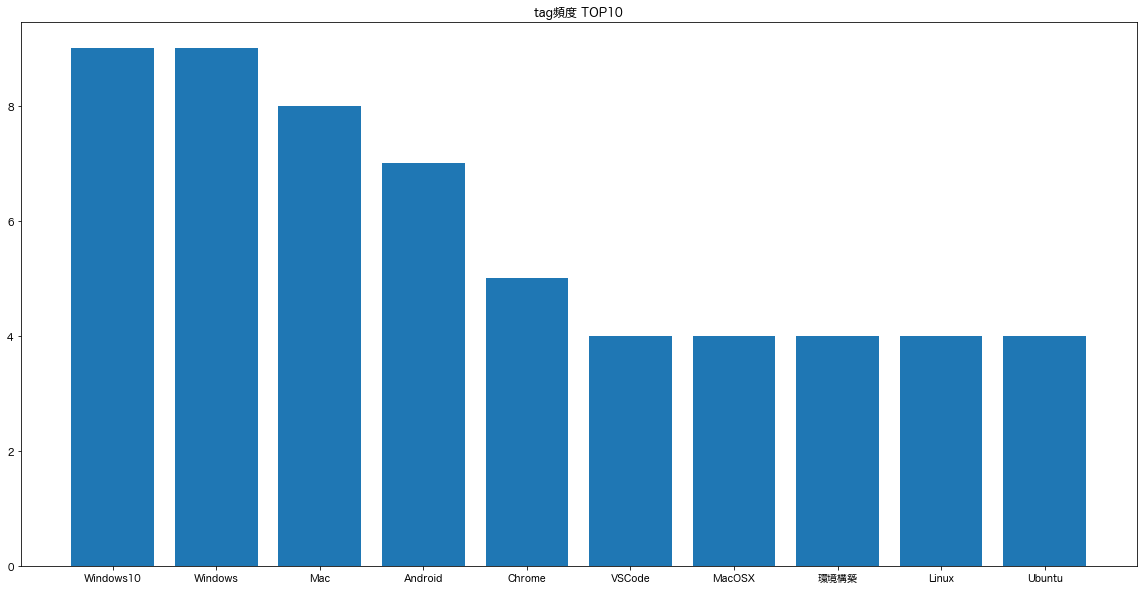

In [111]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


def check_tag(index):
    c = corpus[index]
    vec_lda = lda[c]

    s = doc_index.__getitem__(vec_lda)
    s = sorted(enumerate(s), key=lambda t: t[1], reverse=True)
    
    print(s[:15])
    
    
    frequency = Counter()
    
    for doc_id, sim in s[1:100]:
        tags = df_content['tags_str'][doc_id]
        frequency.update(tags.split(','))
        
    # TOP20のグラフ           
    x = range(10)
    mc = frequency.most_common(10)              # 頻度TOP20を抽出
    ch = [ch[0] for ch in mc]           # ひらがなのリスト
    f = np.array([ch[1] for ch in mc])  # 頻度の数値のリスト


    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    ax.bar(x, f)
    ax.set_xticks(x)
    ax.set_xticklabels(ch , fontsize=10)  #日本語表示はfontproperties=fp
    ax.set_title("tag頻度 TOP10")

    plt.show()
    
    
check_tag(0)

[(10, 1.0), (2238, 0.8862544), (1554, 0.8853122), (7864, 0.8847274), (7030, 0.88421255), (227, 0.8780832), (3000, 0.87795264), (448, 0.86946887), (562, 0.86072856), (98, 0.85789466), (4701, 0.85664374), (2439, 0.8508081), (1524, 0.84966975), (7601, 0.84682083), (2881, 0.84142065)]


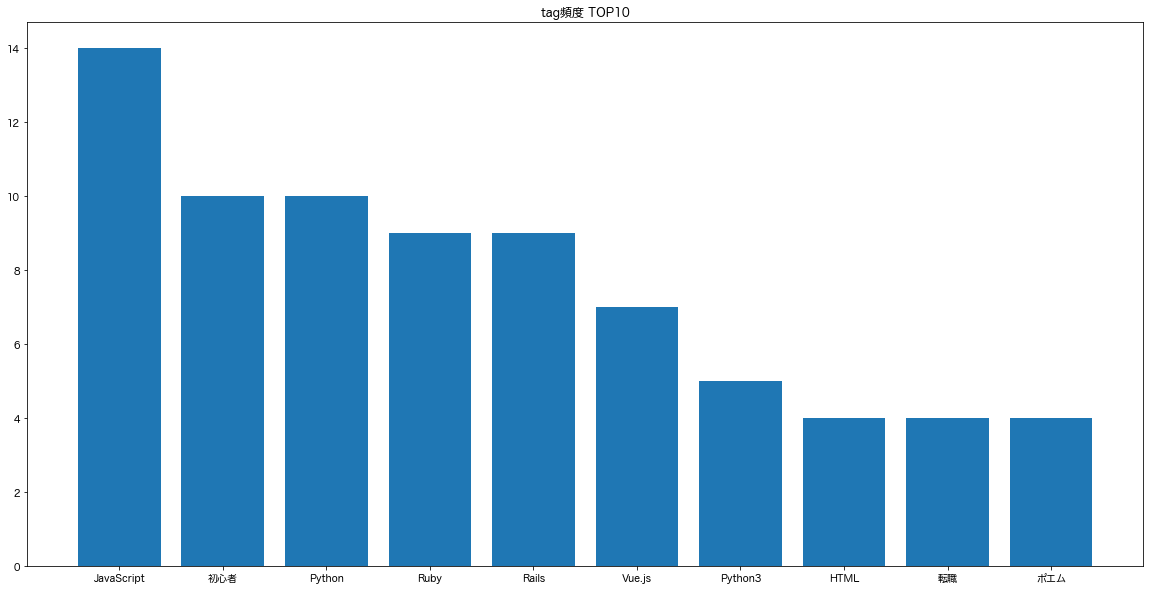

In [112]:
check_tag(10)

[(20, 1.0), (3796, 0.99734604), (3104, 0.9971307), (572, 0.98392177), (8136, 0.9766383), (44, 0.9707874), (784, 0.967509), (4217, 0.9655885), (2602, 0.9653461), (7894, 0.9644503), (1298, 0.964066), (7799, 0.96329075), (811, 0.9615761), (7956, 0.9611647), (2600, 0.95850074)]


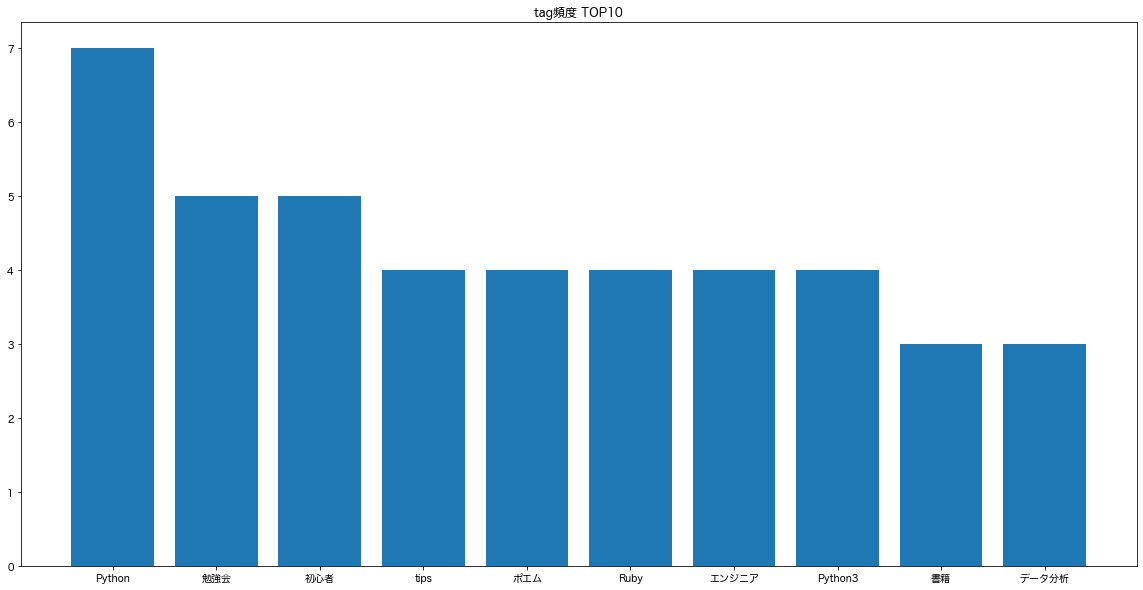

In [116]:
check_tag(20)

[(2, 0.99999946), (3517, 0.78804), (3536, 0.76255757), (101, 0.73011965), (4968, 0.7294658), (3062, 0.72819346), (4142, 0.72775066), (1971, 0.7200485), (4141, 0.71347815), (3259, 0.71169585), (3835, 0.7095678), (7293, 0.6987186), (4, 0.6965829), (5503, 0.6941552), (3519, 0.693528)]


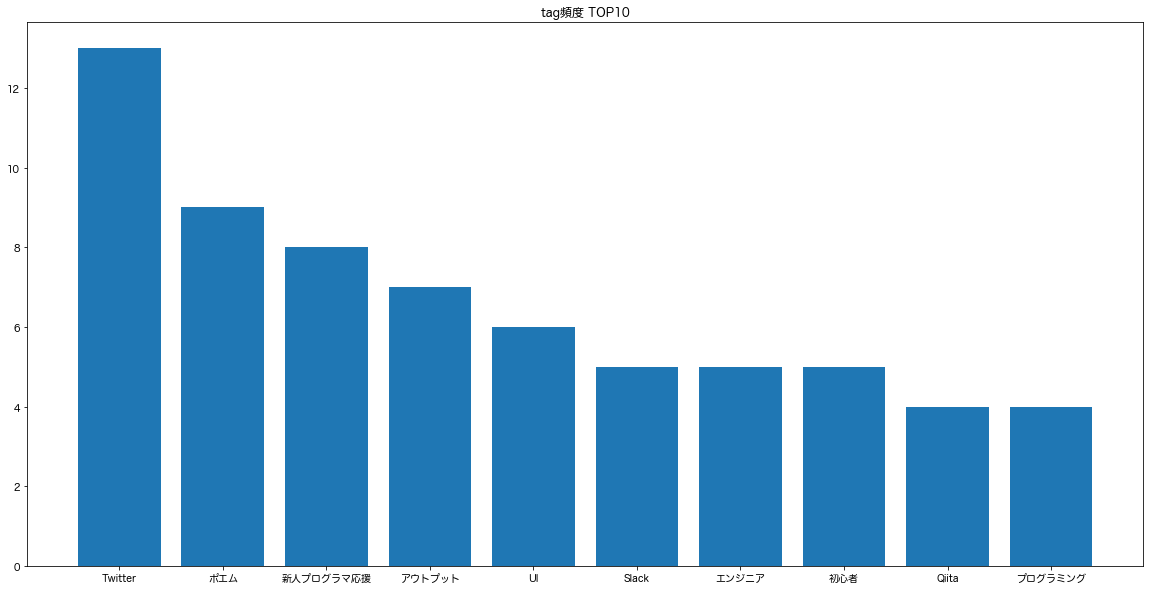

In [117]:
check_tag(2)

# 保存

In [113]:
d.save_as_text("data/dict.txt")
corpora.MmCorpus.serialize("data/cop.mm", corpus)
lda.save("data/lda.model")
doc_index.save("data/sim")

saving dictionary mapping to data/dict.txt
storing corpus in Matrix Market format to data/cop.mm
saving sparse matrix to data/cop.mm
PROGRESS: saving document #0
PROGRESS: saving document #1000
PROGRESS: saving document #2000
PROGRESS: saving document #3000
PROGRESS: saving document #4000
PROGRESS: saving document #5000
PROGRESS: saving document #6000
PROGRESS: saving document #7000
PROGRESS: saving document #8000
saved 8248x14172 matrix, density=0.569% (665655/116890656)
saving MmCorpus index to data/cop.mm.index
saving LdaState object under data/lda.model.state, separately None
saved data/lda.model.state
saving LdaModel object under data/lda.model, separately ['expElogbeta', 'sstats']
storing np array 'expElogbeta' to data/lda.model.expElogbeta.npy
not storing attribute id2word
not storing attribute dispatcher
not storing attribute state
saved data/lda.model
saving MatrixSimilarity object under data/sim, separately None
saved data/sim


In [114]:
from gensim import models, corpora, similarities

corpus = corpora.MmCorpus("data/cop.mm")
lda = models.ldamodel.LdaModel.load("data/lda.model")
d = corpora.Dictionary.load_from_text("data/dict.txt")
doc_index = similarities.docsim.MatrixSimilarity.load("data/sim")

loaded corpus index from data/cop.mm.index
initializing cython corpus reader from data/cop.mm
accepted corpus with 8248 documents, 14172 features, 665655 non-zero entries
loading LdaModel object from data/lda.model
loading expElogbeta from data/lda.model.expElogbeta.npy with mmap=None
setting ignored attribute id2word to None
setting ignored attribute dispatcher to None
setting ignored attribute state to None
loaded data/lda.model
loading LdaState object from data/lda.model.state
loaded data/lda.model.state
loading MatrixSimilarity object from data/sim
loaded data/sim


In [115]:
doc_index.__getitem__(lda[corpus[0]])

array([1.        , 0.13506667, 0.00331247, ..., 0.09635248, 0.03882058,
       0.07169024], dtype=float32)